In [2]:
%load_ext autoreload

In [85]:
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from gpt.model import MLP, Lambda, RevIN
from gpt.utils import flatten, nparams
from gpt.ts import TSTransformer, TransformerEncoder
from einops import rearrange, pack, einsum
import torch.optim as optim
from tqdm.auto import tqdm
import matplotlib
from torchdiffeq import odeint as odeint

In [4]:
torch.set_float32_matmul_precision('medium')

# random sine waves

In [20]:
# xs = torch.tensor(np.sort(np.random.uniform(0, 30, 90)), dtype=torch.float32)
xs = torch.linspace(0, 30, 60, dtype=torch.float32)

num_series = 5010
std = 0.1

periods = (0.2 + torch.rand(size=(num_series, 1)) * 0.5) * np.pi
phases = torch.rand(size=(num_series, 1)) * 2 * np.pi
offsets = torch.randn(size=(num_series, 1)) * 5
noise = torch.randn(size=(num_series, len(xs))) * std
_ys = torch.sin((xs.unsqueeze(0) + phases) / periods) + offsets + noise
ys = _ys.reshape(num_series, -1, 1).to(torch.float32)

xsc, ysc = xs.cuda(), ys.cuda()

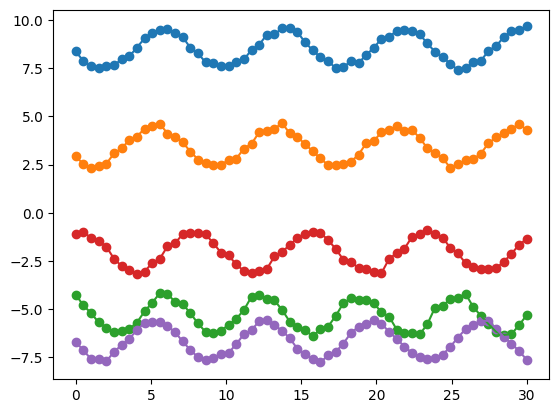

In [21]:
[plt.plot(xs, ys[i,:,0]) for i in range(5)]
[plt.scatter(xs, ys[i,:,0]) for i in range(5)]

In [22]:
class RNNEncoder(nn.Module):
    def __init__(self, dims, hidden_dims, latent_dims):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.rnn = nn.GRUCell(dims + 1, hidden_dims)
        self.proj = nn.Sequential(
            nn.Linear(hidden_dims, hidden_dims * 2),
            nn.GELU(),
            nn.Linear(hidden_dims * 2, hidden_dims),
            nn.GELU(),
            nn.Linear(hidden_dims, latent_dims),
        )

    def forward(self, t, y):
        ys_ts = torch.cat((t[None,:,None].expand(y.shape[0], -1, -1), y), axis=-1)
        ys_ts = rearrange(ys_ts, 'b t d -> t b d')
        hidden = torch.randn(ys_ts.shape[1], self.hidden_dims, dtype=ys_ts.dtype, device=ys_ts.device)
        for i in range(ys_ts.shape[0]):
            hidden = self.rnn(ys_ts[i], hidden)
        return self.proj(hidden)

class ODEFn(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, t, y):
        return self.net(y)
        
class ODERNNEncoder(nn.Module):
    def __init__(self, dims, hidden_dims, latent_dims):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.rnn = nn.GRUCell(dims + 1, hidden_dims)
        self.proj = nn.Sequential(
            nn.Linear(hidden_dims, hidden_dims * 2),
            nn.GELU(),
            nn.Linear(hidden_dims * 2, hidden_dims),
            nn.GELU(),
            nn.Linear(hidden_dims, latent_dims),
        )
        self.net = nn.Sequential(
            nn.Linear(hidden_dims, hidden_dims * 2),
            nn.GELU(),
            nn.Linear(hidden_dims * 2, hidden_dims * 2),
            nn.GELU(),
            nn.Linear(hidden_dims * 2, hidden_dims),
        )
        self.odefn = ODEFn(self.net)
        
    def forward(self, times, y, rtol=1e-3, atol=1e-3):
        # run ode backwards in time to update hidden state between observations
        # at observations, use rnn/gru update
        y = rearrange(y, 'b t d -> t b d')
        t, b, d = y.shape
        hidden = torch.randn(b, self.hidden_dims, dtype=y.dtype, device=y.device)
        min_dt = (times[-1] - times[0]) / 50
        pathloss = 0.
        for i in range(1, len(times)): # everything except first point
            # gru update at observation
            yt = torch.cat((times[-i].expand(b, 1), y[-i]), axis=-1)
            hidden = self.rnn(yt, hidden)
            # ode update
            dt = times[-i] - times[-(i+1)]
            if dt < min_dt:
                hidden = self.odefn(None, hidden) * dt
            else:
                nsteps = max(2, int(torch.ceil((dt) / min_dt)))
                int_times = torch.linspace(times[-i], times[-(i+1)], nsteps, device=y.device)
                paths = odeint(self.odefn, hidden, int_times, rtol=rtol, atol=atol)
                hidden = paths[-1] # last step in trajectory
        # final update
        yt = torch.cat((times[0].expand(b, 1), y[0]), axis=-1)
        hidden = self.rnn(yt, hidden)
        return self.proj(hidden)

In [101]:
class LatentODE(nn.Module):
    def __init__(self, encoder, decoder, projector, odenet, in_dims, reduce_seq_dim=False):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.projector = projector
        self.odefn = ODEFn(odenet)
        self.reduce_seq_dim = reduce_seq_dim
        self.revin = RevIN(in_dims)
        
    def encode(self, ts, ys):
        ys = rearrange(ys, 'b n c -> b c n')
        ys_norm, mean, std = self.revin.normalize(ys)
        ys_norm = rearrange(ys_norm, 'b c n -> b n c')
        z0 = self.encoder(ts, ys_norm)
        if self.reduce_seq_dim:
            z0 = z0.mean(axis=1)
        z0_mean, z0_std = z0.chunk(2, axis=-1)
        return z0_mean, z0_std, mean, std
        # return z0, mean, std

    def resample(self, mean, std):
        z = torch.randn_like(mean)
        return z * std + mean
        
    def integrate(self, z0, ts, rtol=1e-3, atol=1e-3):
        sol = odeint(self.odefn, z0, ts, rtol=rtol, atol=atol)
        return rearrange(sol, 't b d -> b t d')
        
    def decode(self, latents, mean, std):
        out = self.decoder(latents)
        out = rearrange(out, 'b n c -> b c n')
        out = self.revin.unnormalize(out, mean, std)
        out = rearrange(out, 'b c n -> b n c')
        return out

    def forward(self, ts, ys, rtol=1e-3, atol=1e-3):
        z0_mean, z0_std, mean, std = self.encode(ts, ys)
        z0 = self.resample(z0_mean, z0_std)
        # z0, mean, std = self.encode(ts, ys)
        sol = self.integrate(z0, ts, rtol=rtol, atol=atol)
        out = self.decode(sol, mean, std)
        out = self.projector(out)
        return out, sol, z0

In [134]:
data_dim = 1
output_dim = 1
embed_dim = 16

tfm_encoder = TransformerEncoder(
    input_dim=input_dim,
    embed_dim=embed_dim * 2,
    num_layers=2,
    num_heads=4,
    mlp_ratio=2,
    dropout=0.1,
    min_period=0.1,
    max_period=10,
).cuda()
rnn_encoder = RNNEncoder(data_dim, embed_dim, embed_dim * 2).cuda()
odernn_encoder = ODERNNEncoder(data_dim, embed_dim, embed_dim * 2).cuda()

decoder = nn.Sequential(
    nn.Linear(embed_dim, embed_dim * 2),
    nn.GELU(),
    nn.Linear(embed_dim * 2, embed_dim),
    nn.GELU(),
    nn.Linear(embed_dim, data_dim),
)
projector = nn.Linear(data_dim, output_dim)

odenet = nn.Sequential(
    nn.Linear(embed_dim, embed_dim * 2),
    nn.GELU(),
    nn.Linear(embed_dim * 2, embed_dim * 2),
    nn.GELU(),
    nn.Linear(embed_dim * 2, embed_dim),
).cuda()

In [135]:
lode = LatentODE(tfm_encoder, decoder, projector, odenet, data_dim, reduce_seq_dim=True).cuda()

In [136]:
optimizer = optim.AdamW(lode.parameters(), lr=1e-2)

In [137]:
losses = []
losses_recon = []
losses_reg = []

# infft = torch.fft.fft(ysc[:5000,:40], dim=1)
# inp = torch.cat((ysc[:5000,:40], infft.real, infft.imag), dim=-1)

for e in (pbar := tqdm(range(5000))):
    optimizer.zero_grad()
    out, path, z0 = lode(xsc[:40], ysc[:5000,:40])
    # pathdiff = path[:,1:,:] - path[:,:-1,:]
    # cov = torch.diag(1 / torch.std(z0, axis=(0,)) ** 2)
    # L = torch.linalg.cholesky(cov).mH
    # mahalanobis = torch.linalg.norm(
    #     einsum(L, (path[:,1:,:] - path[:,:-1,:]), 'x y, b l y -> b l x'), axis=-1
    # )d
    # loss_reg = mahalanobis.sum()
    loss_recon = F.mse_loss(out, ysc[:5000,:40])
    loss = loss_recon #+ 0.0000001 * loss_reg
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    # losses_reg.append(loss_reg.item())
    # losses_recon.append(loss_recon.item())
    pbar.set_description(f"loss: {loss.item():.4f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (200000x1 and 3x32)

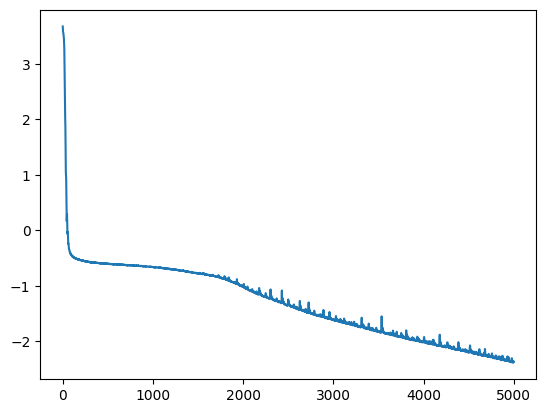

In [109]:
# plt.plot(np.log(np.array(losses_reg) * 0.0000001))
plt.plot(np.log(losses))

In [111]:
inp.shape

torch.Size([5000, 40, 3])

In [112]:
with torch.no_grad():
    infft = torch.fft.fft(ysc, dim=1)
    inp = torch.cat((ysc, infft.real, infft.imag), dim=-1)
    out, path, z0 = lode.forward(xsc, inp)
    out = out.cpu()

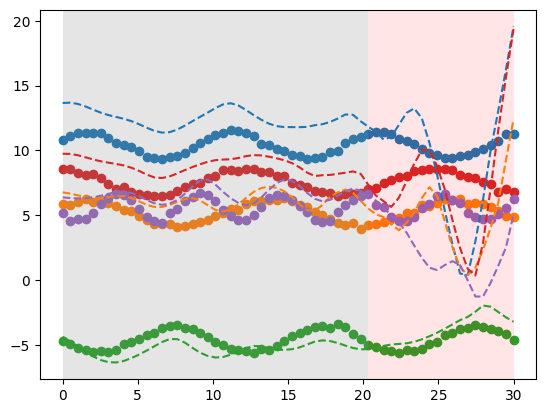

In [118]:
colors = plt.get_cmap('tab20', 10)
ix = 5005
[plt.scatter(xs, ys[j,:,0], color=colors(i)) for i, j in enumerate(range(ix, ix+5))]
[plt.plot(xs, out[j,:,0], color=colors(i), ls='--') for i, j in enumerate(range(ix, ix+5))]
plt.axvspan(xs[0], xs[40], lw=0, alpha=0.2, color='gray') 
plt.axvspan(xs[40], xs[-1], lw=0, alpha=0.1, color='red')